# Powergroup Statistics
This notebook is meant to take in the Anomaly Excel Files and return statistics on the powergroups present.

In [1]:
%%time
# imports

import os
import sys
import json
import time
import joblib
import importlib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# thisdir = os.getcwd()
# topdir = os.path.abspath(os.path.join(thisdir, '../../../'))
# sys.path.append(topdir)

# import tools.iotools as iotools
# import tools.dftools as dftools
import plottools as plottools
# from tools.dataloadertools import MEDataLoader

import functions
importlib.reload(functions);
from functions import *
# from functions import save_digis_png
# from functions import extract_data_2d
# #from functions import extract_data_2d_multi_lumis
# from functions import plot_fpix_digi
# from functions import remove_cross
# from functions import add_cross
# from pyarrow.parquet import ParquetDataset
    
#Used to load an extension that can skip the remaining execution of a cell. 
#Used to skip the training so we don't constantly retrain a model
%load_ext skip_kernel_extension
%reload_ext skip_kernel_extension

optimized_powerGroupStringsList = np.array(['FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG4','FPix_BmO_D3_ROG3','FPix_BmO_D2_ROG3','FPix_BmO_D1_ROG3','FPix_BmO_D3_ROG2','FPix_BmO_D2_ROG2','FPix_BmO_D1_ROG2','FPix_BmO_D3_ROG1','FPix_BmO_D2_ROG1','FPix_BmO_D1_ROG1','FPix_BmI_D3_ROG1','FPix_BmI_D2_ROG1','FPix_BmI_D1_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D2_ROG2','FPix_BmI_D1_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D2_ROG3','FPix_BmI_D1_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG4','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG4','FPix_BpO_D1_ROG3','FPix_BpO_D2_ROG3','FPix_BpO_D3_ROG3','FPix_BpO_D1_ROG2','FPix_BpO_D2_ROG2','FPix_BpO_D3_ROG2','FPix_BpO_D1_ROG1','FPix_BpO_D2_ROG1','FPix_BpO_D3_ROG1','FPix_BpI_D1_ROG1','FPix_BpI_D2_ROG1','FPix_BpI_D3_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D2_ROG2','FPix_BpI_D3_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D2_ROG3','FPix_BpI_D3_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG4'])
#A list of all of the quarters of the detector
QUARTERS = np.array([['FPix_BmI_D3_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG1','FPix_BmI_D2_ROG2','FPix_BmI_D2_ROG3','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG1','FPix_BmI_D1_ROG2','FPix_BmI_D1_ROG3','FPix_BmI_D1_ROG4'], ['FPix_BmO_D3_ROG1','FPix_BmO_D3_ROG2','FPix_BmO_D3_ROG3','FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG1','FPix_BmO_D2_ROG2','FPix_BmO_D2_ROG3','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG1','FPix_BmO_D1_ROG2','FPix_BmO_D1_ROG3','FPix_BmO_D1_ROG4'], ['FPix_BpI_D1_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG1','FPix_BpI_D2_ROG2','FPix_BpI_D2_ROG3','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG1','FPix_BpI_D3_ROG2','FPix_BpI_D3_ROG3','FPix_BpI_D3_ROG4'], ['FPix_BpO_D1_ROG1','FPix_BpO_D1_ROG2','FPix_BpO_D1_ROG3','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG1','FPix_BpO_D2_ROG2','FPix_BpO_D2_ROG3','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG1','FPix_BpO_D3_ROG2','FPix_BpO_D3_ROG3','FPix_BpO_D3_ROG4']])
#Used in the load excel function to go to the right directory. 
LOSS_THRESHOLD = 4e5
ANOMALY_CUTOFF = .4

CPU times: user 1.48 s, sys: 322 ms, total: 1.81 s
Wall time: 2.44 s


In [2]:
def loadExcel(ERAS, VERSIONS, PARTS, verbose=False):
    #List of dataframes for concatenating
    dataframes = []
    #Loop over each ERA
    for index, ERA in enumerate(ERAS):
        #Extract the required information
        VERSION = VERSIONS[index]
        PART = PARTS[index]
        #Get the path
        DIR_NAME = f"Era_{ERA}_LossThresh_{np.format_float_scientific(LOSS_THRESHOLD, trim='-')}_AnomalyCutoff_{int(ANOMALY_CUTOFF*100)}%" 
        #print(f"Pulling Excel File From: {DIR_NAME}")
        excelFilepath = f"/eos/user/j/jomorris/SWAN_projects/NMF Testing/Anomaly Excel Files/{DIR_NAME}/Era_{ERA}_v{VERSION}_p{PART}_Anomalies.xlsx"
        if verbose: print(f"Excel File at `{excelFilepath}` Loaded!")
        #Load into pandas
        df = pd.read_excel(excelFilepath)
        #Append to list
        dataframes.append(df)
    #Concatenate each dataframe together
    columns = df.columns
    finalDataframe = pd.concat(dataframes, ignore_index=True)
    return finalDataframe

def load_OMS_JSON(ERAS, VERSIONS, PARTS, verbose=False):
    #List of dataframes for concatenating
    dataframes = []
    #Loop over each ERA
    for index, ERA in enumerate(ERAS):
        #Extract the required information
        VERSION = VERSIONS[index]
        PART = PARTS[index]
        #Get the path
        oms_json = f'omsdata/omsdata_Run2024{ERA}-v{VERSION}.json'
        #Import the OMS_JSON
        #Turn the json file into a python dictionary
        with open(oms_json, 'r') as f:
            oms_filters = json.load(f)
        filter_keys = [
            'run_number',
            'lumisection_number',
            'pileup',
            "beams_stable", #also add these flags for checking how often each specific pileup occurs
            "cms_active",
            "bpix_ready",
            "fpix_ready",
            "tibtid_ready",
            "tob_ready",
            "tecp_ready",
            "tecm_ready"
        ]
        if verbose: print(f"OMS JSON File at `{oms_json}` Loaded!")
            
        oms_filters = {key: val for key, val in oms_filters.items() if key in filter_keys}
        #Then turn the dictionary into a dataframe and extract just the desired run number
        oms_df = pd.DataFrame.from_dict(oms_filters)
        #Filter based on each flag being true
        oms_df = oms_df[(oms_df["beams_stable"] == True) & (oms_df["cms_active"] == True) &
                      (oms_df["bpix_ready"] == True) & (oms_df["fpix_ready"] == True) &
                      (oms_df["tibtid_ready"] == True) & (oms_df["tob_ready"] == True) &
                      (oms_df["tecp_ready"] == True) & (oms_df["tecm_ready"] == True)]        
        # print(oms_df.head())
        #Append to list
        dataframes.append(oms_df)
    #Concatenate each dataframe together
    finalDataframe = pd.concat(dataframes, ignore_index=True)
    return finalDataframe

#Function to take in a pandas dataframe of an Excel Anomaly File. (Or at least any dataframe with the 'Anomaly_Type' and 'Powergroup' columns)
#Return 
def plotAnomalousPowergroupOccurances(dataframe, excluded_powergroups=[]):
    #Create a fig for plotting
    fig, ax = plt.subplots(1, 1, figsize=(5, 8))
    #Select just the single disk anomalies
    singleDiskAnomalies = dataframe[dataframe["Anomaly_Type"]=="Single Disk"]
    powergroups = singleDiskAnomalies["Powergroup"].to_list()
    print(f"There are {len(powergroups)} Single Disk Anomalies")#"\n{powergroups}")
    anomalousPowergroups = []
    #Loop over each powergroup and split it on a ':'
    for powergroup in powergroups:
        temp = powergroup.split(':') #just wraps the string in a list if there are no ':' characters
        anomalousPowergroups.extend(temp)

    #print("\n")
    #print(f"There are {len(anomalousPowergroups)} Powergroups:\n{anomalousPowergroups}")

    #Get the counts of each unique powergroup
    uniquePowergroups, counts = np.unique(anomalousPowergroups, return_counts=True)
    #print("\n")
    #print(f"There are {len(uniquePowergroups)} Unique Anomalous Powergroups:\n{uniquePowergroups}")

    #Construct a data format which stores every powergroup and how many times they were anomalous
    anomalousDict = dict(zip(optimized_powerGroupStringsList, np.zeros_like(optimized_powerGroupStringsList, dtype=int))) #First make a dictionary where each powergroup has no occurances
    for index, anomalousPowergroup in enumerate(uniquePowergroups):
        anomalousDict[anomalousPowergroup] = counts[index]

    #print('\n')
    #print(f"Anomalous Powergroups Dict:\n{anomalousDict}")

    #Plot the data
    data = np.zeros((92, 56))#Create empty array to store the data in
    all_occurances = [] #create an empty array to store all of the non-excluded occurances in
    for powergroup, occurance in anomalousDict.items():
        #Get the indices of the powergroups
        powerGroupSlice, diskSlice = powerGroupToIndex(powergroup)

        #If we are excluding the powergroup from plotting (maybe mini-bias scans or the like), then set the occurances to 0
        if (powergroup in excluded_powergroups):
            data[powerGroupSlice, diskSlice] = 0
            print(f"Powergroup: {powergroup} Excluded!")
        else:
            data[powerGroupSlice, diskSlice] = occurance
            all_occurances.append(occurance)
            
            #Add box over each cell with their occurance
            ax.text(diskSlice.start+(diskSlice.stop - diskSlice.start)/2, powerGroupSlice.start+(powerGroupSlice.stop - powerGroupSlice.start)/2, f"{occurance}", 
                    bbox=dict(fill=False, edgecolor='red', linewidth=0), fontsize=13, weight=1000, ha='center', va='center')
            
    #calculate the average occurance of anomalies
    average_occurance = np.average(all_occurances)
    std_dev = np.std(all_occurances)
    #print(f"Average Occurances: {average_occurance} ± {std_dev}")
    
    fig, ax = plot_digis_ax(data, -1, -1, 1, fig=fig, axis=ax)
    fig.suptitle("Anomalous Powergroups Occurance", fontsize=18)
    # Get the images on an axis
    im = ax.images
    # Assume colorbar was plotted last one plotted last
    cb = im[-1].colorbar 
    cb.set_label("Occurance", fontsize=16)
    #Add box detailing number of events looked at and other stats
    text = f"Avg Occurance:\n{int(average_occurance)} ± {int(std_dev)}\nN={len(powergroups)}\nAnomalies"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) #Boundingbox properties
    ax.text(1.50, 1, text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='center', bbox=props)
    
    
    
    
    occurance_df = pd.DataFrame(anomalousDict, index=[0]).T.reset_index()
    occurance_df.columns = ["Powergroup", "Occurance"]
    
    return fig, ax, data, occurance_df

## Import Anomaly Excel Files into Pandas

In [3]:
#List of the ERAs, their VERSIONs, and their PARTs. Make sure to keep lists in line!
ERA = ["C", "D", "E", "E", "F","F", "G", "H", "I", "I"]
VERSION = [1, 1, 1, 2, 1,1, 1, 1, 1, 2] 
PART = [1, 1, 1, 1, 1,2, 1, 1, 1, 1]
# ERA=["F", "G", "H", "I", "I"]
# VERSION = [1, 1, 1, 1, 2]
# PART = [2, 1, 1, 1, 1]

# exclude_mini_bias = ["FPix_BpO_D1_ROG1"]
exclude_mini_bias = ["FPix_BpO_D1_ROG1", "FPix_BmO_D1_ROG2"]

#Load in the data
dataframe = loadExcel(ERA, VERSION, PART, verbose=False)
# print(dataframe.head())

fig, ax, plotting_data, anomaly_df = plotAnomalousPowergroupOccurances(dataframe, excluded_powergroups=exclude_mini_bias)
# print(anomaly_df)

anomaly_df.hist(bins=30);

FileNotFoundError: [Errno 2] No such file or directory: '/eos/user/j/jomorris/SWAN_projects/NMF Testing/Anomaly Excel Files/Era_C_LossThresh_4e+05_AnomalyCutoff_40%/Era_C_v1_p1_Anomalies.xlsx'

-------------------------------------------


[]

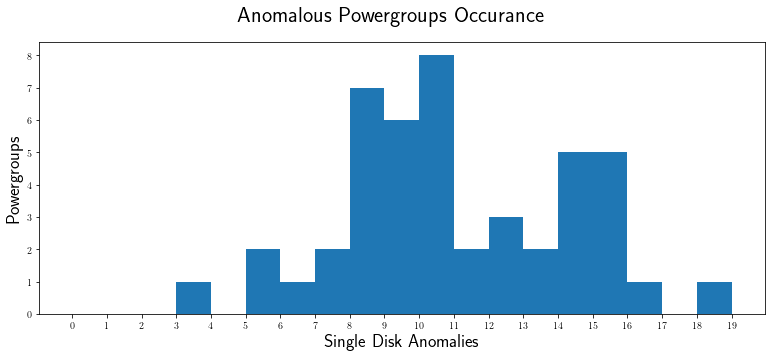

In [37]:
#Plotting 1D distrbution of number of occurances
#Exclude the excluded powergroups from the dataframe
anomaly_df = anomaly_df[(anomaly_df["Powergroup"] != "FPix_BpO_D1_ROG1") & (anomaly_df["Powergroup"] != "FPix_BmO_D1_ROG2")]
print("-------------------------------------------")
# print(anomaly_df)
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
occurances = anomaly_df["Occurance"].to_list()
bins = np.arange(0, np.max(occurances)+1, 1)
ax.hist(occurances, bins=bins)

fig.suptitle("Anomalous Powergroups Occurance", fontsize=22)
average_occurance = np.average(occurances)
std_dev = np.std(occurances)
#Add box detailing number of events looked at and other stats
# text = f"Avg Occurance:\n{int(average_occurance)} ± {int(std_dev)}\nN={np.sum(occurances)}\nAnomalies"
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) #Boundingbox properties
# ax.text(.15, .98, text, transform=ax.transAxes, fontsize=14,
#     verticalalignment='top', horizontalalignment='center', bbox=props)
ax.set_xticks(bins)
ax.set_xlabel("Single Disk Anomalies", fontsize=18)

ax.set_ylabel("Powergroups", fontsize=18)

plt.plot()

# Pileup Statistics
This will go through each Single Disk anomaly and match the Start_LS with the pileup for that specific anomaly. This is for investigating and seeing if high pileup is more likely to cause anomalies. 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Finished!


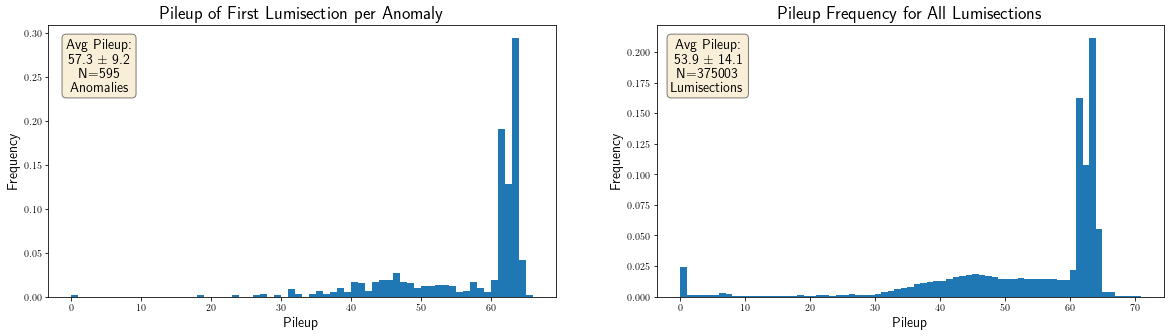

In [17]:
%time
#List of the ERAs, their VERSIONs, and their PARTs. Make sure to keep lists in line!
# ERA = ["C"]
# VERSION = [1]
# PART = [1]
# ERA = ["C", "D", "E", "E", "F"]
# VERSION = [1, 1, 1, 2, 1] 
# PART = [1, 1, 1, 1, 1]
# ERA=["F", "G", "H", "I", "I"]
# VERSION = [1, 1, 1, 1, 2]
# PART = [2, 1, 1, 1, 1]
ERA = ["C", "D", "E", "E", "F","F", "G", "H", "I", "I"]
VERSION = [1, 1, 1, 2, 1,1, 1, 1, 1, 2] 
PART = [1, 1, 1, 1, 1,2, 1, 1, 1, 1]

#Load all of the oms_json's into one data frame
oms_df = load_OMS_JSON(ERA, VERSION, PART, verbose=False)
# print(oms_df.head())
# oms_df.to_excel(f"temp.xlsx", index=False, engine='openpyxl')

#Load in the data
dataframe = loadExcel(ERA, VERSION, PART, verbose=False)
# print(dataframe.head())

#Select all of the single disk anomalies
singleDiskAnomalies = dataframe[dataframe["Anomaly_Type"]=="Single Disk"]
start_lumisections = singleDiskAnomalies["Start_LS"].to_list()

#Merge the two dataframes. how=inner to take only common rows between them
#left_on and right_on need to both be specified as they have different column names in the data vs. oms_json
merged_df = pd.merge(singleDiskAnomalies, oms_df, how='inner', left_on=["Run_Number", "Start_LS"], right_on=["run_number", "lumisection_number"])

#Exclude the two weird powergroups. Remember to use Pandas way of combining masks. Checked this worked with Era C
#NOTE: This only excludes lumisections where the ONLY anomaly is in these powergroups. If there are more than 1 anomalous powergroup and this is one of them, it is NOT excluded!
merged_df = merged_df[(merged_df["Powergroup"] != "FPix_BpO_D1_ROG1") & (merged_df["Powergroup"] != "FPix_BmO_D1_ROG2")]


#Extract the pileup for each single disk anomaly for plotting
pileup = np.array(merged_df["pileup"].to_list())
avg_pileup = np.average(pileup)
std_pileup = np.std(pileup)
#Extract the pileup of ALL of the Lumisections that we looked at for anomalies
# oms_df.hist(column='pileup', bins=bins, density=True)
all_pileup = np.array(oms_df["pileup"].to_list())
# all_pileup = all_pileup[all_pileup > 1] #Exlude the lumisections with pileup = 0 as they do not cause anomalies and throw off frequency data
avg_pileup_all = np.average(all_pileup)
std_pileup_all = np.std(all_pileup)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
#Bins are all of the integers from min pileup to max pileup with a step size of 1
bins = np.arange(int(np.min(pileup)), int(np.max(pileup) + 1), 1)
# print(f"Bins: {bins}");
#Plot the Pileup of all of the anomalies
ax[0].hist(pileup, bins = bins, density=True);#, weights=pileup_normalize);
ax[0].set_xlabel("Pileup", fontsize=14)
ax[0].set_ylabel("Frequency", fontsize=14)
ax[0].set_title("Pileup of First Lumisection per Anomaly", fontsize=18)
#Add box detailing number of events looked at and other stats
text = f"Avg Pileup:\n{avg_pileup:.1f} ± {std_pileup:.1f}\nN={len(pileup)}\nAnomalies"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) #Boundingbox properties
ax[0].text(.1, .95, text, transform=ax[0].transAxes, fontsize=14,
    verticalalignment='top', horizontalalignment='center', bbox=props)


#Plot the pileup of ALL of the Lumisections that we looked at for anomalies
#Bins are all of the integers from min pileup to max pileup with a step size of 1
bins = np.arange(int(np.min(all_pileup)), int(np.max(all_pileup) + 1), 1)
# print(f"Bins: {bins}");
#Plot the Pileup of all of the anomalies
ax[1].hist(all_pileup, bins = bins, density=True);#, weights=pileup_normalize);
ax[1].set_xlabel("Pileup", fontsize=14)
ax[1].set_ylabel("Frequency", fontsize=14)
ax[1].set_title("Pileup Frequency for All Lumisections", fontsize=18)
#Add box detailing number of events looked at and other stats
text = f"Avg Pileup:\n{avg_pileup_all:.1f} ± {std_pileup_all:.1f}\nN={len(all_pileup)}\nLumisections"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) #Boundingbox properties
ax[1].text(.1, .95, text, transform=ax[1].transAxes, fontsize=14,
    verticalalignment='top', horizontalalignment='center', bbox=props);
print("Finished!")

## Notes on the above graph
The first graph is produced by importing all of the Eras, versions, and parts in 2024. 
1. Then, we select ONLY the `single disk` anomalies. 
2. Then, we take the `first lumisection` of EACH anomaly and find the `pileup` of that lumisection. 
    * We assume that that `pileup` is constant for the entire anomaly. 

So the first plot is just a probability density distribution of the pileup that occurs for all of the single disk anomalies. While you might immediately think that higher pileup causes more anomalies, you must first compare that to the pileup of every single lumisection. The pileup may not be a flat distribution. The chance for any specific pileup may not all be equal. So, we plot all of the pileups in the 2024 OMS JSON. This yields 375,003 lumisections. The pileup of each anomaly turns out to have basically the exact same shape as the pileup for every sigle lumisection. This implies that each pileup has roughly the same chance of causing an anomly, and that pileup and Single Disk anomalies might not be exactly correlated. 

NOTE! The N=595 anomalies here is different than the N=561 Anomalies in the powergroup statistics because in the powergroup statistics we just exclude the entire anomaly if it contains an excluded powergroup. But in the pileup statistics an anomaly is only excluded if the ONLY anomalous powergroup is one of the excluded ones. So an anomaly with two powergroups out, one of them being excluded, is still included in the pileup statistics. 